# NYC Air Quality & Demographic

**Goal**: Analyze the connection between air quality and demographics profile on the borough and community district level. 

*Note: Support the The Clean Air Coalition with key findings and visuals to include in their op-ed, advocating for a new air quality bill.*

In [234]:
# load in necessary libraries
import pandas as pd 
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
import statsmodels.api as sm
import statsmodels.formula.api as smf

Workflow

1. Examine Raw Data: I begin by inspecting the raw dataset to understand its structure, including data types, dimensions, and preliminary insights.

2. Segmentation and Review: I break down the data into smaller, more focused subsets to assess data quality in detail and identify potential problems. This step involves initial cleaning and basic transformations.

3. Function Application: Once I have a grasp of the overall data structure and relationships, I apply appropriate functions to the remaining raw data, prioritizing readability and maintainability within the notebook.

4. Statistical Analysis: After organizing and preparing the data, I proceed to apply statistical techniques such as correlation analysis and linear regression. 

## Data Sources

### Air Quality Data

**Data Source:** https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r

### Demographic Data

**Data Source:** https://s-media.nyc.gov/agencies/dcp/assets/files/excel/data-tools/census/census2020/nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx

### Spatial Boiundaries

Data Source: https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

## Data Cleaning and Merging

### Read in raw datasets

In [4]:
# Air Quality
aq_raw = aq_raw = pd.read_csv('Air_Quality_20231222.csv')

# Demographics
demo2020_raw = pd.read_excel('./nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx', sheet_name='2020')
demo2010_raw = pd.read_excel('./nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx', sheet_name='2010')

# Boundaries
boro_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

boro = gpd.read_file(boro_url)

community_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

community = gpd.read_file(community_url)

In [5]:
aq_raw.sample(5)

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
1913,605361,386,Ozone (O3),Mean,ppb,CD,413,Queens Village (CD13),Summer 2018,06/01/2018,31.94,NaN
13440,177155,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,210,Coney Island - Sheepshead Bay,Winter 2008-09,12/01/2008,11.12,NaN
16029,170347,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,107,Upper West Side (CD7),Annual Average 2012,12/01/2011,10.44,NaN
13251,130974,651,Cardiovascular hospitalizations due to PM2.5 (...,Estimated annual rate,"per 100,000 adults",Borough,1,Bronx,2005-2007,01/01/2005,31.30,NaN
11683,741037,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,203,Bedford Stuyvesant - Crown Heights,Winter 2020-21,12/01/2020,23.09,NaN


In [6]:
# list 'name' column values
aq_raw['Name'].unique()

array(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Ozone (O3)',
       'Asthma emergency department visits due to PM2.5',
       'Annual vehicle miles traveled',
       'Asthma hospitalizations due to Ozone',
       'Respiratory hospitalizations due to PM2.5 (age 20+)',
       'Boiler Emissions- Total SO2 Emissions',
       'Cardiovascular hospitalizations due to PM2.5 (age 40+)',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Annual vehicle miles travelled (cars)',
       'Annual vehicle miles travelled (trucks)',
       'Cardiac and respiratory deaths due to Ozone',
       'Asthma emergency departments visits due to Ozone',
       'Outdoor Air Toxics - Formaldehyde',
       'Outdoor Air Toxics - Benzene', 'Deaths due to PM2.5'],
      dtype=object)

In [7]:
# list 'time period' column values
aq_raw['Time Period'].unique()

array(['Annual Average 2011', 'Annual Average 2009',
       'Annual Average 2015', 'Annual Average 2020', 'Winter 2010-11',
       'Annual Average 2013', 'Winter 2014-15', 'Annual Average 2021',
       'Summer 2009', 'Annual Average 2017', 'Winter 2009-10',
       'Summer 2017', 'Summer 2018', 'Winter 2018-19', 'Summer 2014',
       'Winter 2016-17', 'Annual Average 2014', 'Winter 2011-12',
       'Summer 2020', '2-Year Summer Average 2009-2010',
       'Annual Average 2016', 'Annual Average 2018', 'Summer 2013',
       'Summer 2021', 'Summer 2012', 'Winter 2008-09', 'Winter 2017-18',
       'Winter 2013-14', 'Annual Average 2019', 'Summer 2016',
       'Summer 2010', 'Winter 2020-21', 'Summer 2011', 'Winter 2015-16',
       'Summer 2015', 'Summer 2019', 'Winter 2019-20', '2012-2014',
       '2015-2017', 'Annual Average 2010', 'Winter 2012-13', '2009-2011',
       '2016', '2005', '2005-2007', 'Annual Average 2012', '2015', '2013',
       '2011', '2014'], dtype=object)

In [8]:
# Convert the 'Start Date' column to datetime
aq_raw['Start_Date'] = pd.to_datetime(aq_raw['Start_Date'])

- 'Name' contains multiple air quality indicators and there are different measurement units.
- 'Geo Type Name', 'Geo Place Name': Geographical information.
- 'Geo Join ID' is a common identifier could be used for merging
- 'Time Period' have different length of time
- 'Data Value': Air Quality measurement
- 'Message' column contains no information

In [9]:
demo2020_raw.head()

,Year,GeoType,Borough,GeoID,BCT2020,Name,CDType,NTAType,Pop1,Pop1P,...,ROcHH2,ROcHH2P,ROcHH3,ROcHH3P,ROcHH4,ROcHH4P,ROcHH5pl,ROcHH5plP,LandAcres,LandAcresP
0,2020,NYC2020,New York City,0,NaN,NYC,NaN,NaN,8804190,100.0,...,670144,28.3,374447,15.8,263906,11.2,254065,10.7,192288.84,NaN
1,2020,Boro2020,Manhattan,1,NaN,Manhattan,NaN,NaN,1694251,100.0,...,196690,31.4,75343,12.0,43007,6.9,27660,4.4,14500.01,NaN
2,2020,Boro2020,Bronx,2,NaN,Bronx,NaN,NaN,1472654,100.0,...,102118,24.0,77071,18.1,58043,13.7,61014,14.4,26989.99,NaN
3,2020,Boro2020,Brooklyn,3,NaN,Brooklyn,NaN,NaN,2736074,100.0,...,215925,29.1,122906,16.6,84476,11.4,89012,12.0,44401.01,NaN
4,2020,Boro2020,Queens,4,NaN,Queens,NaN,NaN,2405464,100.0,...,139627,27.6,89400,17.6,70538,13.9,68090,13.4,69583.41,NaN


As per client request, racial and age are the most interested factors for this study. Below are variables to keep. 

| Name                              | Id        |
| :-------------------------------- | :-------- |
| Median age (years)                | MdAge     |
| Age dependency ratio              | AgDpdRt   |
| Old-age dependency ratio          | OdAgDpdRt |
| Child dependency ratio            | ChldDpdRt |
| Population per acre               | PopAcre   |
| For migrant workers               | VHUMigWrk |
| Hispanic                          | Hsp1      |
| White non-Hispanic                | WNH       |
| Black non-Hispanic                | BNH       |
| Asian non-Hispanic                | ANH       |
| Some other race non-Hispanic      | ONH       |
| Non-Hispanic of two or more races | TwoPlNH   |

- 'GeoID' has a different order of boroughs compare to 'Geo Join ID' in AQ dataset
- Match the name of 'GeoID' for merging

In [10]:
boro.head()

,OBJECTID,BoroCode,BoroName,Shape__Area,Shape__Length,geometry
0,1,5,Staten Island,1.623623e+09,325908.454204,"MULTIPOLYGON (((-74.05051 40.56643, -74.05047 ..."
1,2,1,Manhattan,6.365202e+08,357674.419620,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ..."
2,3,2,Bronx,1.187177e+09,463169.939778,"MULTIPOLYGON (((-73.89681 40.79582, -73.89694 ..."
3,4,3,Brooklyn,1.934138e+09,728132.409218,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ..."
4,5,4,Queens,3.041419e+09,888171.049923,"MULTIPOLYGON (((-73.82645 40.59054, -73.82643 ..."


(-74.28337200220007, -73.67223129338034, 40.47517224893852, 40.93651102033928)

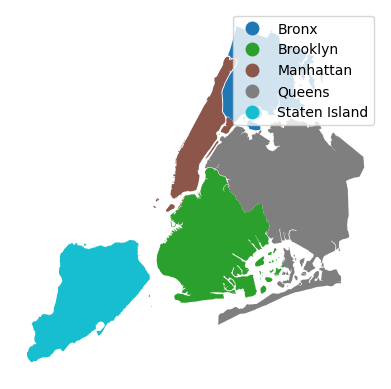

In [11]:
boro.plot(column='BoroName', legend=True).axis('off')

In [12]:
community.head()

,OBJECTID,BoroCD,Shape__Area,Shape__Length,geometry
0,1,308,4.560400e+07,38232.751052,"POLYGON ((-73.95829 40.67984, -73.95596 40.679..."
1,2,414,1.955772e+08,210910.875979,"MULTIPOLYGON (((-73.90972 40.56530, -73.90973 ..."
2,3,204,5.552218e+07,31358.425193,"POLYGON ((-73.90269 40.84459, -73.90271 40.844..."
3,4,228,9.293902e+07,122138.942942,"MULTIPOLYGON (((-73.77322 40.86080, -73.77326 ..."
4,5,205,3.831698e+07,29443.048118,"POLYGON ((-73.89138 40.86171, -73.89142 40.861..."


(-74.28337200220007, -73.67223129338034, 40.47517224893857, 40.93651102033823)

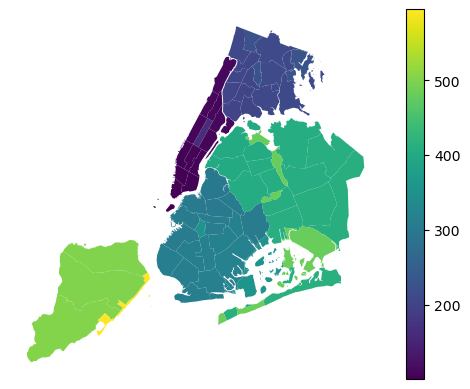

In [13]:
community.plot(column='BoroCD', legend=True).axis('off')

### EDA

#### Air Quality

In [14]:
# Check missing values
aq_raw.isna().sum()

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           0
Geo Place Name        0
Time Period           0
Start_Date            0
Data Value            0
Message           16218
dtype: int64

'Message' column is not meaningful.

In [15]:
# Check duplicated records
aq_raw.duplicated().sum() 

0

There are no duplicated rows.

Focus on `borough` and `community` district level analyses as per client request.

In [16]:
# Drop unused column
aq = aq_raw.drop('Message', axis=1)
# Filter Community and Borough records
aq = aq[aq['Geo Type Name'].isin(['CD','Borough'])]

In [17]:
# Reorder AQ's Geo Join ID of Boros to match with that of Demo census data
aq_map = {
    'Manhattan': 1,
    'Bronx': 2,
    'Brooklyn': 3
}

aq['Geo Join ID'] = aq['Geo Place Name'].map(aq_map).fillna(aq['Geo Join ID'])

aq.groupby(['Geo Join ID', 'Geo Place Name']).size()

Geo Join ID  Geo Place Name                   
1.0          Manhattan                            148
2.0          Bronx                                148
3.0          Brooklyn                             148
4.0          Queens                               148
5.0          Staten Island                        148
                                                 ... 
413.0        Queens Village (CD13)                100
414.0        Rockaway and Broad Channel (CD14)    100
501.0        St. George and Stapleton (CD1)       100
502.0        South Beach and Willowbrook (CD2)    100
503.0        Tottenville and Great Kills (CD3)    100
Length: 64, dtype: int64

In [22]:
aq.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
19,550028,375,Nitrogen dioxide (NO2),Mean,ppb,CD,201.0,Mott Haven and Melrose (CD1),Annual Average 2017,2017-01-01,21.25
20,336723,375,Nitrogen dioxide (NO2),Mean,ppb,CD,101.0,Financial District (CD1),Winter 2014-15,2014-12-01,30.40
21,741126,375,Nitrogen dioxide (NO2),Mean,ppb,CD,101.0,Financial District (CD1),Annual Average 2021,2021-01-01,21.61
22,165858,375,Nitrogen dioxide (NO2),Mean,ppb,CD,102.0,Greenwich Village and Soho (CD2),Winter 2010-11,2010-12-01,36.79
23,166625,375,Nitrogen dioxide (NO2),Mean,ppb,CD,102.0,Greenwich Village and Soho (CD2),Summer 2009,2009-06-01,31.63


In [23]:
# Devide AQ data into two dataframes by Borough and Community District
aq_boro = aq[aq['Geo Type Name'] == 'Borough']
aq_cd = aq[aq['Geo Type Name'] == 'CD']

In [34]:
# Group AQ data by 'Indicator ID', 'Name', 'Measure', 'Time Period', and 'Start_Date', and calculate the mean of 'Data Value' as 'Mean Data Value'
aq_boro_describe = aq_boro.groupby(['Indicator ID', 'Name', 'Measure', 'Time Period', 'Start_Date']).agg({'Data Value': 'mean'}).reset_index().rename(columns={'Data Value': 'Mean Data Value'})
aq_cd_describe = aq_cd.groupby(['Indicator ID', 'Name', 'Measure', 'Time Period', 'Start_Date']).agg({'Data Value': 'mean'}).reset_index().rename(columns={'Data Value': 'Mean Data Value'})

In [35]:
aq_boro_describe.groupby(['Indicator ID', 'Name', 'Measure']).size()

Indicator ID  Name                                                    Measure                             
365           Fine particles (PM 2.5)                                 Mean                                    39
375           Nitrogen dioxide (NO2)                                  Mean                                    39
386           Ozone (O3)                                              Mean                                    14
639           Deaths due to PM2.5                                     Estimated annual rate (age 30+)          4
640           Boiler Emissions- Total SO2 Emissions                   Number per km2                           2
641           Boiler Emissions- Total PM2.5 Emissions                 Number per km2                           2
642           Boiler Emissions- Total NOx Emissions                   Number per km2                           2
643           Annual vehicle miles traveled                           million miles                   

In [31]:
aq_cd_describe.groupby(['Indicator ID', 'Name', 'Measure']).size()

Indicator ID  Name                                     Measure                     
365           Fine particles (PM 2.5)                  Mean                            39
375           Nitrogen dioxide (NO2)                   Mean                            39
386           Ozone (O3)                               Mean                            14
643           Annual vehicle miles traveled            million miles                    2
644           Annual vehicle miles travelled (cars)    million miles                    2
645           Annual vehicle miles travelled (trucks)  million miles                    2
646           Outdoor Air Toxics - Benzene             Annual average concentration     1
647           Outdoor Air Toxics - Formaldehyde        Annual average concentration     1
dtype: int64

In [36]:
# subset aq_boro_describe where 'Indicator ID' = 639, 648, 650, 651, 657 
aq_pm25_illness = aq_boro_describe[aq_boro_describe['Indicator ID'].isin([639, 648, 650, 651, 657])]

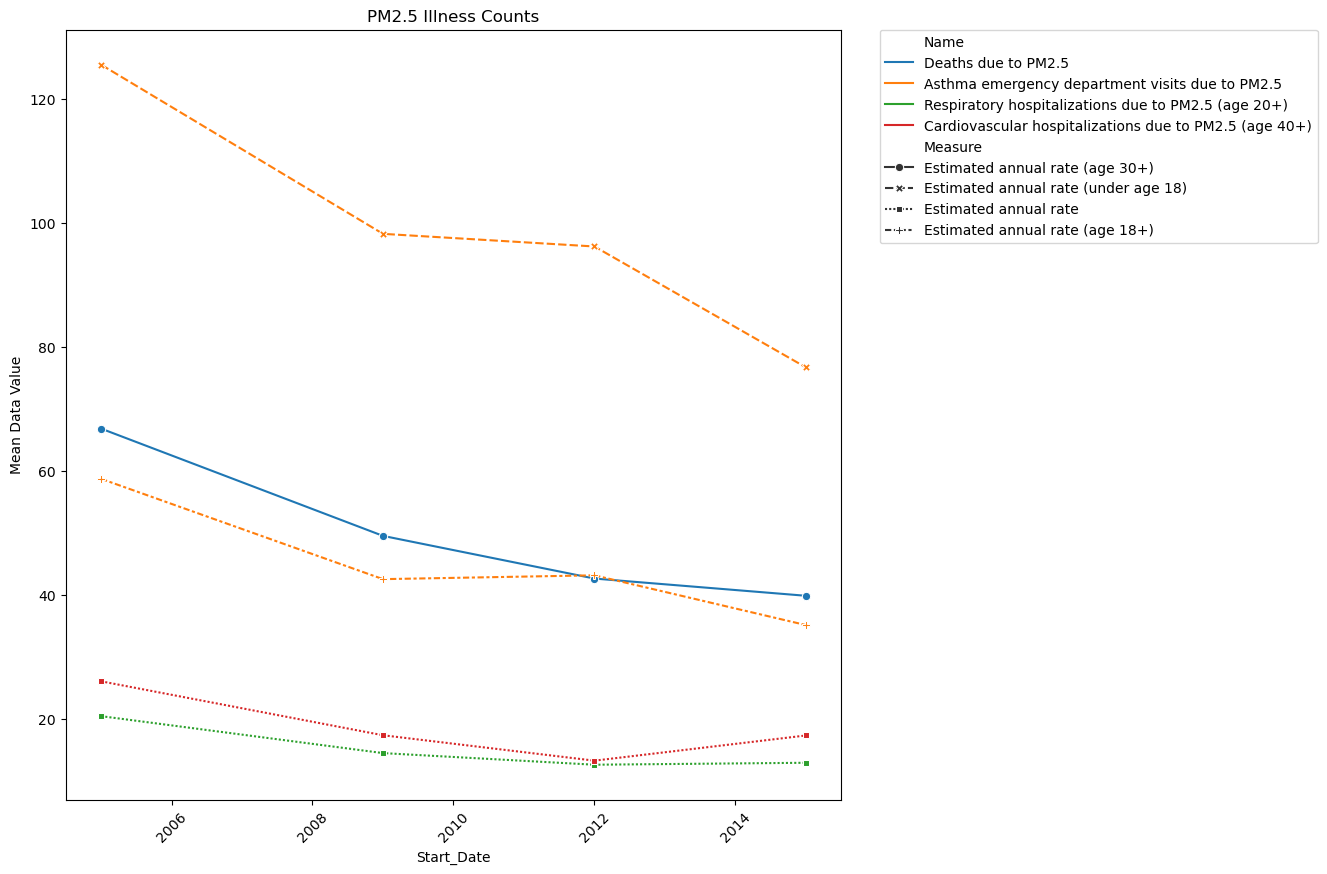

In [48]:
# plot aqp_pm25_illness by start date and mean data value
plt.figure(figsize=(10, 10))
sns.lineplot(data=aq_pm25_illness, x='Start_Date', y='Mean Data Value', hue='Name', style='Measure', markers=True, dashes=True)
plt.xticks(rotation=45)
plt.title('PM2.5 Illness Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In general, the number of illness count due to PM2.5 is decreasing over time, although the Respiratory hospitalizations for age 20+ and Cardiovascular hospitalizations for age 40+ slightly increased in 2015.

It is also noticable that the number of Asthma ER visits of younger people (age under 18) is significantly higher.

In [43]:
# subset aq_boro_describe where 'Indicator ID' = 652, 653, 655, 659, 661
aq_o3_illness = aq_boro_describe[aq_boro_describe['Indicator ID'].isin([652, 653, 655, 659, 661])]

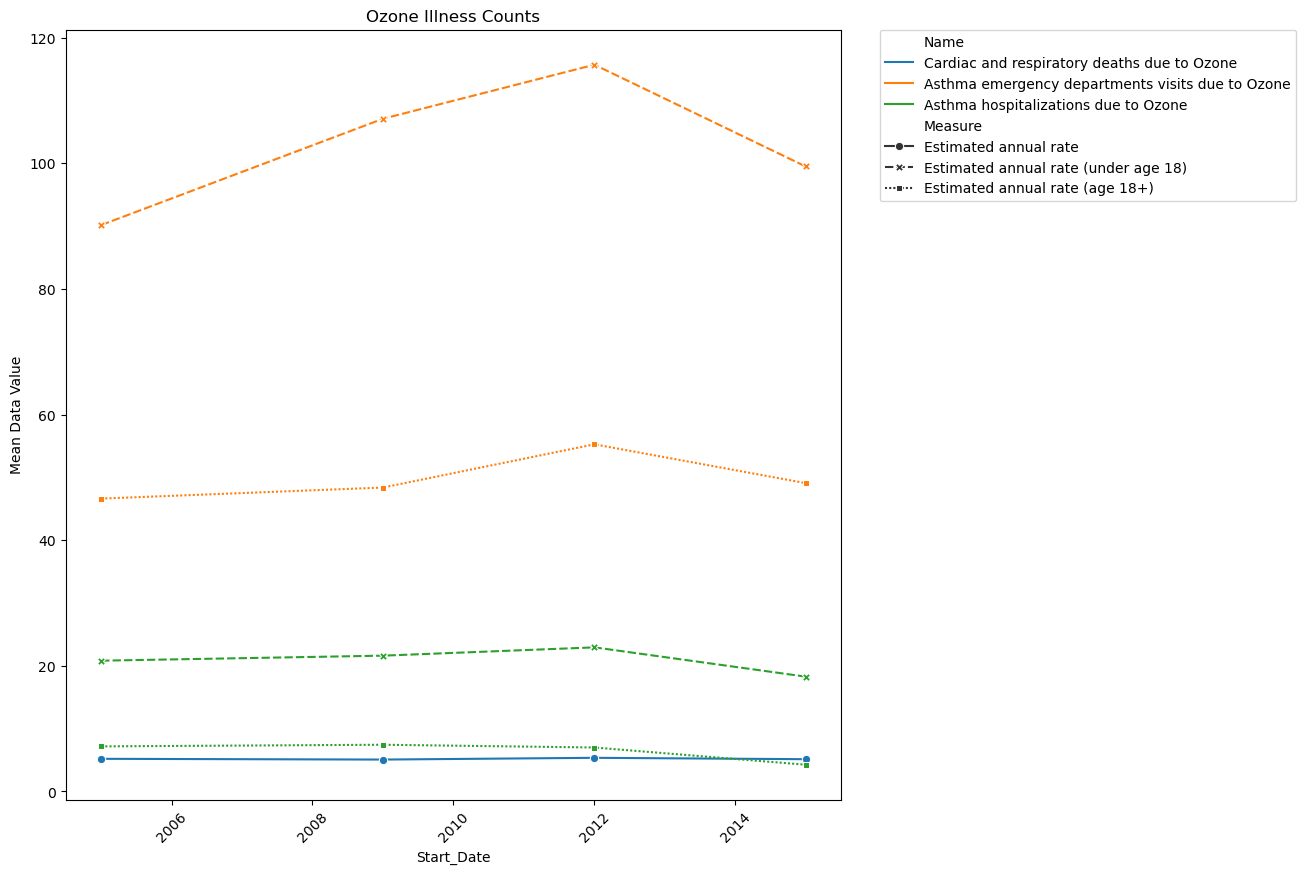

In [52]:
# plot aqp_o3_illness by start date and mean data value
plt.figure(figsize=(10, 10))
sns.lineplot(data=aq_o3_illness, x='Start_Date', y='Mean Data Value', hue='Name', style='Measure', markers=True, dashes=True)
plt.xticks(rotation=45)
plt.title('Ozone Illness Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The number of Cardiac and respiratory deaths due to Ozone and Asthma hospitalizations due to Ozone are not changing much over time. However, the number of Asthma ED visits due to Ozone has a peak in 2012, expecially the estimated rate for youth under 18 years old is much higher than others.

In [53]:
# Subset aq_cd_describe where 'Indicator ID' = 643, 644, 645
aq_vmt = aq_cd_describe[aq_cd_describe['Indicator ID'].isin([643, 644, 645])]

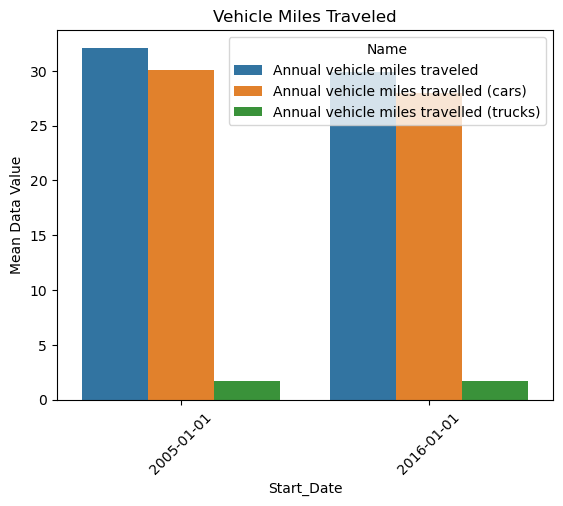

In [57]:
# Plot aq_vmt by start date and mean data value
sns.barplot(data=aq_vmt, x='Start_Date', y='Mean Data Value', hue='Name')
plt.xticks(rotation=45)
plt.title('Vehicle Miles Traveled')
plt.show()

The annual vehicle miles traveled slightly decreased from 2005 to 2016, and cars have much higher VMT than trucks.

In [72]:
# Subset aq_cd_describe where 'Indicator ID' = 365
aq_pm25 = aq_cd_describe[aq_cd_describe['Indicator ID'] == 365]
# Keep the first 6 characters of 'Time Period' column
aq_pm25['Time Period'] = aq_pm25['Time Period'].str[:6]

C:\Users\chenj\AppData\Local\Temp\ipykernel_36368\2663475773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_pm25['Time Period'] = aq_pm25['Time Period'].str[:6]


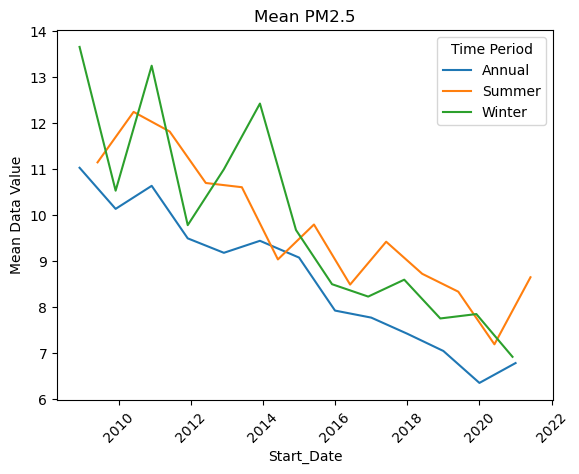

In [75]:
# Plot aq_pm25 by start date and mean data value
sns.lineplot(data=aq_pm25, x='Start_Date', y='Mean Data Value', hue='Time Period')
plt.xticks(rotation=45)
plt.title('Mean PM2.5')
plt.show()

The overall mean PM2.5 concentration in NYC is decreasing. Summer and Winter have higher PM2.5 concentration than the annual average.

In [78]:
# Subset aq_cd_describe where 'Indicator ID' = 375
aq_no2 = aq_cd_describe[aq_cd_describe['Indicator ID'] == 375]
# Keep the first 6 characters of 'Time Period' column
aq_no2['Time Period'] = aq_no2['Time Period'].str[:6]

C:\Users\chenj\AppData\Local\Temp\ipykernel_36368\1794333413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_no2['Time Period'] = aq_no2['Time Period'].str[:6]


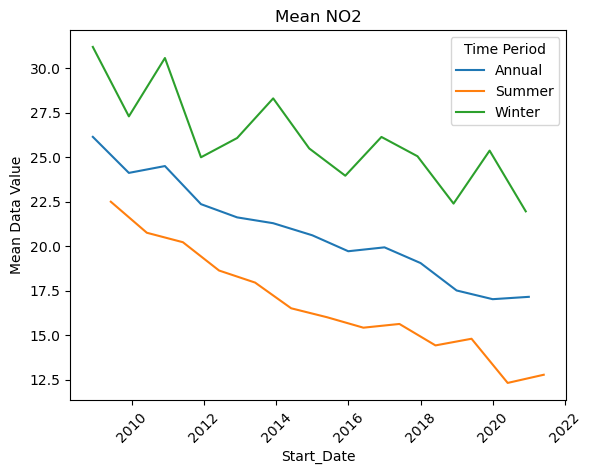

In [79]:
# Plot aq_no2 by start date and mean data value
sns.lineplot(data=aq_no2, x='Start_Date', y='Mean Data Value', hue='Time Period')
plt.xticks(rotation=45)
plt.title('Mean NO2')
plt.show()

The overall mean NO2 concentration in NYC is decreasing. Winter has a higher NO2 concentration than the annual average and Summer has a lower NO2 concentration.

In [80]:
# Subset aq_cd_describe where 'Indicator ID' = 386
aq_o3 = aq_cd_describe[aq_cd_describe['Indicator ID'] == 386]
# Keep the first 6 characters of 'Time Period' column
aq_o3['Time Period'] = aq_o3['Time Period'].str[:6]

C:\Users\chenj\AppData\Local\Temp\ipykernel_36368\2450673239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_o3['Time Period'] = aq_o3['Time Period'].str[:6]


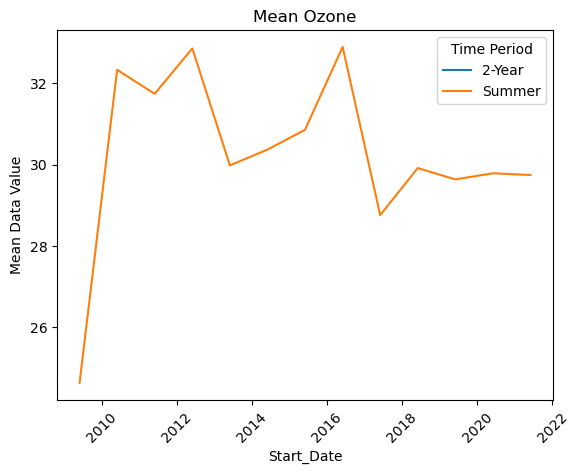

In [81]:
# Plot aq_o3 by start date and mean data value
sns.lineplot(data=aq_o3, x='Start_Date', y='Mean Data Value', hue='Time Period')
plt.xticks(rotation=45)
plt.title('Mean Ozone')
plt.show()

The Ozone data has only summer records. It seems that the pattern of Ozone is slightly decreasing over time, but the trend is not clear.

Since the demographics dataset only include 2010 and 2020 data, I want to focus on recent air quality data that are later than 2020-01-01. 

In [83]:
aq_recent = aq[aq['Start_Date'] >= '2020-01-01'] # Filter records later than 2020

In [84]:
aq_recent.groupby(['Indicator ID', 'Name','Time Period']).size()

Indicator ID  Name                     Time Period        
365           Fine particles (PM 2.5)  Annual Average 2020    64
                                       Annual Average 2021    64
                                       Summer 2020            64
                                       Summer 2021            64
                                       Winter 2020-21         64
375           Nitrogen dioxide (NO2)   Annual Average 2020    64
                                       Annual Average 2021    64
                                       Summer 2020            64
                                       Summer 2021            64
                                       Winter 2020-21         64
386           Ozone (O3)               Summer 2020            64
                                       Summer 2021            64
dtype: int64

Considering that the demographic dataset is for the year 2020, and that "Summer 2020" exists in all major air quality indicators, I will use the "Summer 2020" data for the initial analysis to ensure consistency in the timeframe and to provide a more relevant assessment of the relationship between air quality and demographic factors.

In [85]:
# Filter AQ records for 2020
aq_2020 = aq_recent[aq_recent['Time Period'] == 'Summer 2020']

In [86]:
# Pivot the table to get the AQ data in wide format

def aq_pivoter(df, id_column, name_column, value_column, time_column):
    # Pivot the table
    pivoted_table = df.pivot_table(index=id_column, columns=name_column, values=value_column).reset_index()

    # 
    retain_cols = df.drop(
        columns=[
            name_column, value_column, 'Unique ID', 'Indicator ID', 'Measure', 'Measure Info','Geo Type Name'
            ]
        ).drop_duplicates(
            subset=[id_column,time_column]
            )
    
    # 
    pivoted_table = pd.merge(pivoted_table, retain_cols, on=id_column)

    return pivoted_table

In [87]:
# Pivot the table for AQ data 2020
aq_2020_pivoted = aq_pivoter(aq_2020,'Geo Join ID','Name','Data Value' ,'Time Period')

In [88]:
aq_2020_pivoted.head()

,Geo Join ID,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Ozone (O3),Geo Place Name,Time Period,Start_Date
0,1.0,7.80,15.97,28.77,Manhattan,Summer 2020,2020-06-01
1,2.0,7.24,13.16,30.85,Bronx,Summer 2020,2020-06-01
2,3.0,6.94,10.82,29.69,Brooklyn,Summer 2020,2020-06-01
3,4.0,6.87,10.00,30.52,Queens,Summer 2020,2020-06-01
4,5.0,6.58,7.83,28.61,Staten Island,Summer 2020,2020-06-01


In [92]:
# Spatial join AQ data with Boro
aq_2020_boro = gpd.GeoDataFrame(
    pd.merge(
        boro,
        aq_2020_pivoted,
        left_on='BoroCode',
        right_on='Geo Join ID'
    )
)

# Spatial join AQ data with Community District
aq_2020_cd = gpd.GeoDataFrame(
    pd.merge(
        community,
        aq_2020_pivoted,
        left_on='BoroCD',
        right_on='Geo Join ID'
    )
)

In [ ]:
aq_2020_boro.set_crs(4326)
aq_2020_cd.set_crs(4326)

<Axes: title={'center': 'PM 2.5 in NYC Boroughs 2020'}>

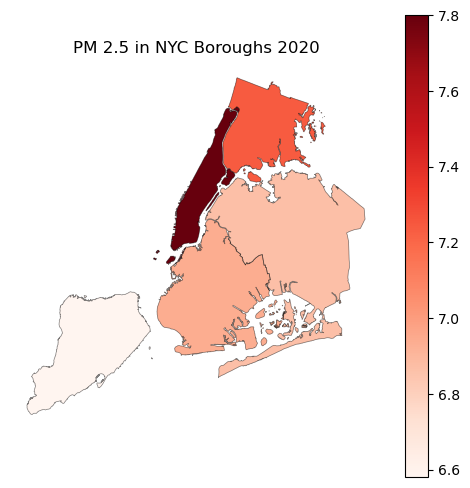

In [97]:
# Plot PM 2.5 for 2020 by borough
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('PM 2.5 in NYC Boroughs 2020')
aq_2020_boro.plot(column='Fine particles (PM 2.5)', cmap='Reds', legend=True, ax=ax)
# add boundary
boro.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

<Axes: title={'center': 'PM 2.5 in NYC Community Districts 2020'}>

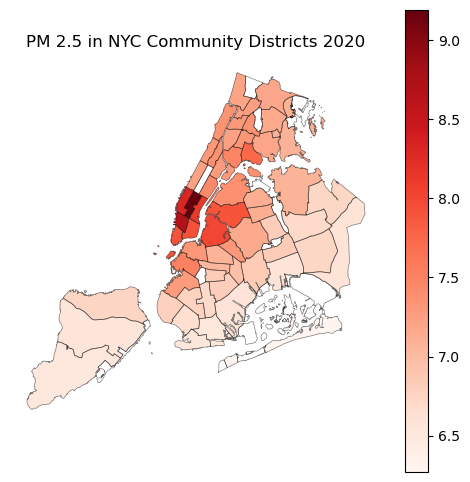

In [98]:
# Plot PM 2.5 for 2020 by community district
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('PM 2.5 in NYC Community Districts 2020')
aq_2020_cd.plot(column='Fine particles (PM 2.5)', cmap='Reds', legend=True, ax=ax)
# add boundary
community.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

Lower Manhattan and some Community Districts in Brooklyn and Queens that are close to the East River have higher PM 2.5 levels.

<Axes: title={'center': 'Ozone in NYC Boroughs 2020'}>

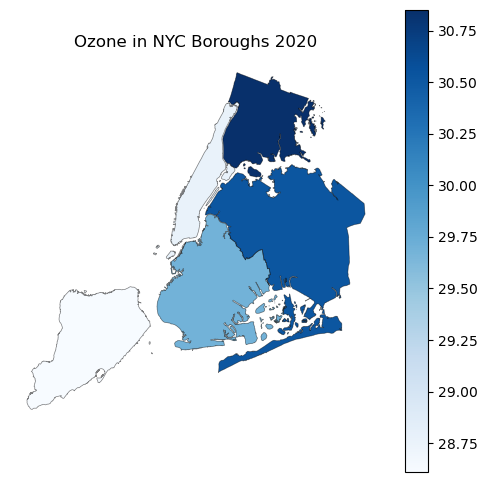

In [100]:
# Plot Ozone for 2020 by borough
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Ozone in NYC Boroughs 2020')
aq_2020_boro.plot(column='Ozone (O3)', cmap='Blues', legend=True, ax=ax)
# add boundary
boro.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

<Axes: title={'center': 'Ozone in NYC Community Districts 2020'}>

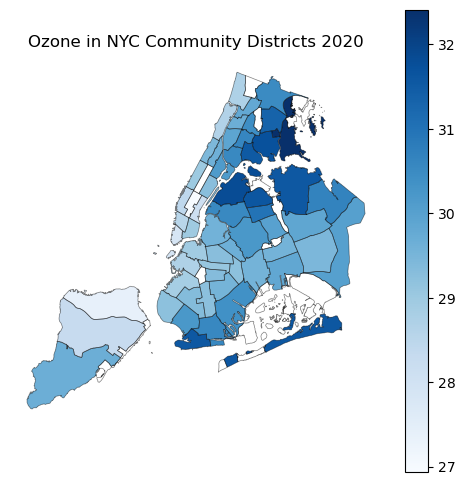

In [101]:
# Plot Ozone for 2020 by community district
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Ozone in NYC Community Districts 2020')
aq_2020_cd.plot(column='Ozone (O3)', cmap='Blues', legend=True, ax=ax)
# add boundary
community.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

Overall, Bronx and Queens have higher Ozone level, and some community districts in Brooklyn such as Coney Island and Rockaway also have high Ozone level.

<Axes: title={'center': 'NO2 in NYC Boroughs 2020'}>

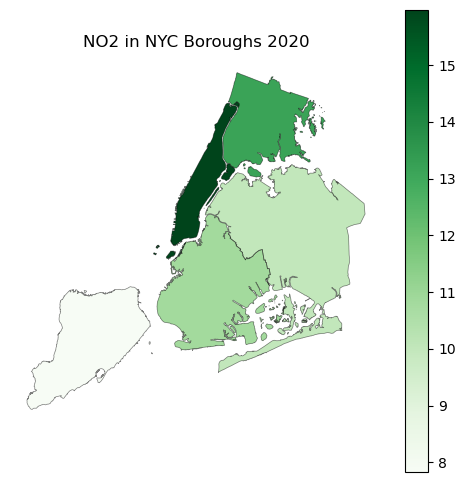

In [104]:
# Plot NO2 for 2020 by borough
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('NO2 in NYC Boroughs 2020')
aq_2020_boro.plot(column='Nitrogen dioxide (NO2)', cmap='Greens', legend=True, ax=ax)
# add boundary 
boro.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

<Axes: title={'center': 'NO2 in NYC Community Districts 2020'}>

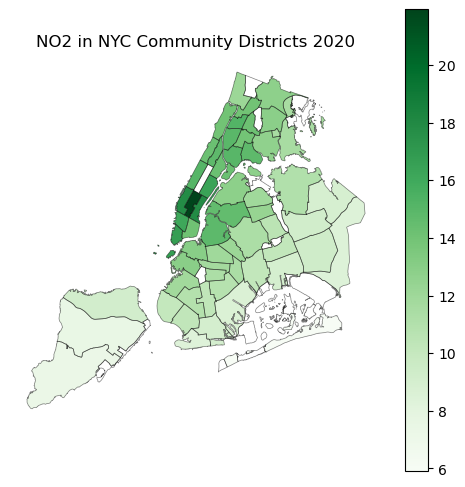

In [105]:
# Plot NO2 for 2020 by community district
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('NO2 in NYC Community Districts 2020')
aq_2020_cd.plot(column='Nitrogen dioxide (NO2)', cmap='Greens', legend=True, ax=ax)
# add boundary
community.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

Manhattan has the highest NO2 level overall, and midtown has the highest NO2 level in Manhattan.

### Demographics

In [384]:
demo_2020= demo2020_raw[
    demo2020_raw['GeoType'].isin(['CD', 'Boro2020']) & 
    (demo2020_raw['CDType'] != 'JIA')]

demo_2020 = demo_2020[['GeoType','Borough','GeoID',
              'Name','Pop1','MdAge','AgDpdRt',
              'OdAgDpdRt','ChldDpdRt','PopAcre','VHUMigWrk',
              'Hsp1','WNH','BNH','ANH','ONH','TwoPlNH']]

In [385]:
# Rename columns
demo_2020.rename(columns={'GeoID':'Geo Join ID'}, inplace=True)

In [386]:
demo_2020.head()

,GeoType,Borough,Geo Join ID,Name,Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
1,Boro2020,Manhattan,1,Manhattan,1694251,36.9,43.8,24.0,19.7,116.8,52,402640,793294,199592,219624,16112,62989
2,Boro2020,Bronx,2,Bronx,1472654,35.6,58.4,20.8,37.6,54.6,18,806463,130796,419393,67766,19866,28370
3,Boro2020,Brooklyn,3,Brooklyn,2736074,35.2,54.8,21.1,33.7,61.6,48,516426,968427,729696,370776,37579,113170
4,Boro2020,Queens,4,Queens,2405464,39.1,52.9,23.9,29.0,34.6,46,667861,549358,381375,656583,66175,84112
5,Boro2020,Staten Island,5,Staten Island,495747,40.4,63.0,28.0,35.0,13.5,4,96960,277981,46835,58753,3900,11318


In [387]:
# check missing values
demo_2020.isna().sum()

GeoType        0
Borough        0
Geo Join ID    0
Name           0
Pop1           0
MdAge          0
AgDpdRt        0
OdAgDpdRt      0
ChldDpdRt      0
PopAcre        0
VHUMigWrk      0
Hsp1           0
WNH            0
BNH            0
ANH            0
ONH            0
TwoPlNH        0
dtype: int64

In [388]:
# check duplicated records
demo_2020.duplicated().sum()

0

There is no missing values and duplicated records in demo_2020

In [389]:
# Filter demo_2020 by borough
demo_2020_boro = demo_2020[demo_2020['GeoType'] == 'Boro2020']
# Filter demo_2020 by community district
demo_2020_cd = demo_2020[demo_2020['GeoType'] == 'CD']

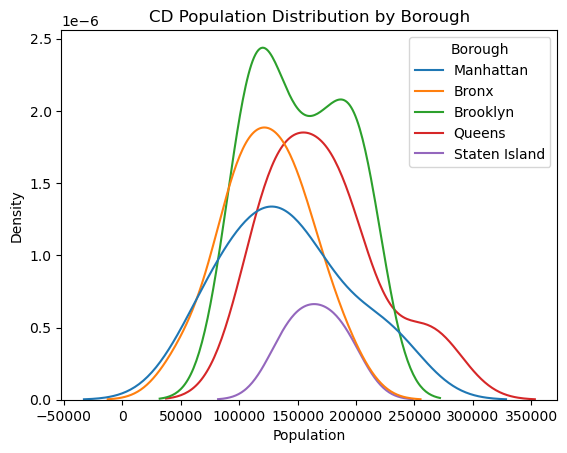

In [390]:
# Plot population at borough level use density plot to show distribution of community district population
sns.kdeplot(data=demo_2020_cd, x='Pop1', hue='Borough', fill=False)
plt.title('CD Population Distribution by Borough')
xlabel = plt.xlabel('Population')

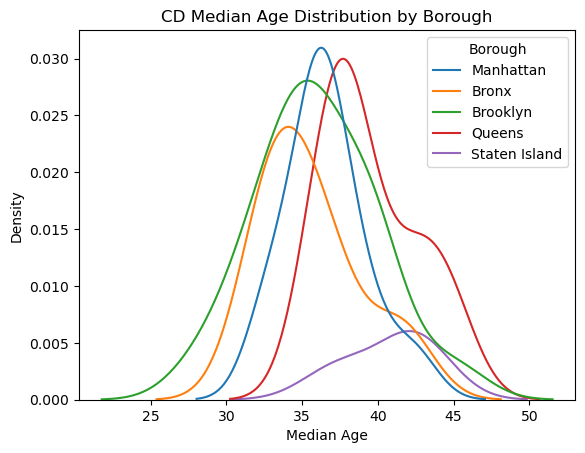

In [391]:
# Plot population median age at borough level use density plot to show distribution of community district population
sns.kdeplot(data=demo_2020_cd, x='MdAge', hue='Borough', fill=False)
plt.title('CD Median Age Distribution by Borough')
xlabel = plt.xlabel('Median Age')


In [392]:
# Spatial join demo_2020_boro with aq_2020_boro
demo_aq_2020_boro = gpd.GeoDataFrame(
    pd.merge(
        demo_2020_boro,
        aq_2020_boro,
        on='Geo Join ID'
    )
)

In [427]:
demo_aq_2020_cd.columns

Index(['GeoType', 'Borough', 'GeoID', 'Name', 'Pop1', 'MdAge', 'AgDpdRt',
       'OdAgDpdRt', 'ChldDpdRt', 'PopAcre', 'VHUMigWrk', 'Hsp1', 'WNH', 'BNH',
       'ANH', 'ONH', 'TwoPlNH', 'OBJECTID', 'BoroCD', 'Shape__Area',
       'Shape__Length', 'geometry', 'PM25', 'NO2', 'O3', 'GeoName',
       'Time Period', 'Start_Date'],
      dtype='object')

In [393]:
demo_aq_2020_boro.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [394]:
# Spatial join demo_2020_cd with aq_2020_cd
demo_aq_2020_cd = gpd.GeoDataFrame(
    pd.merge(
        demo_2020_cd,
        aq_2020_cd,
        on='Geo Join ID'
    )
)

In [395]:
# select columns to keep in demo_aq_2020_boro
demo_aq_2020_boro = demo_aq_2020_boro[[
    'Geo Join ID', 'Borough','Fine particles (PM 2.5)', 'Ozone (O3)', 'Nitrogen dioxide (NO2)', 'Pop1', 'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt', 'PopAcre', 'VHUMigWrk', 'Hsp1', 'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH'
]]

In [396]:
demo_aq_2020_boro

,Geo Join ID,Borough,Fine particles (PM 2.5),Ozone (O3),Nitrogen dioxide (NO2),Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
0,1,Manhattan,7.80,28.77,15.97,1694251,36.9,43.8,24.0,19.7,116.8,52,402640,793294,199592,219624,16112,62989
1,2,Bronx,7.24,30.85,13.16,1472654,35.6,58.4,20.8,37.6,54.6,18,806463,130796,419393,67766,19866,28370
2,3,Brooklyn,6.94,29.69,10.82,2736074,35.2,54.8,21.1,33.7,61.6,48,516426,968427,729696,370776,37579,113170
3,4,Queens,6.87,30.52,10.00,2405464,39.1,52.9,23.9,29.0,34.6,46,667861,549358,381375,656583,66175,84112
4,5,Staten Island,6.58,28.61,7.83,495747,40.4,63.0,28.0,35.0,13.5,4,96960,277981,46835,58753,3900,11318


In [397]:
def demo_plotter(df, column, title, cmap, legend=True):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    df.plot(column=column, cmap=cmap, legend=True, ax=ax)
    # add boundary
    community.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)

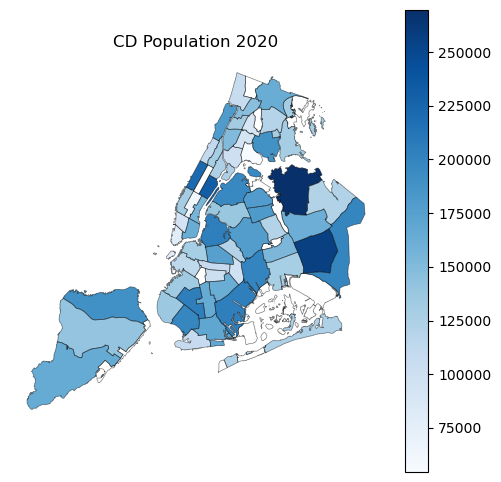

In [398]:
# Plot population at community district level
demo_plotter(demo_aq_2020_cd, 'Pop1', 'CD Population 2020', 'Blues')

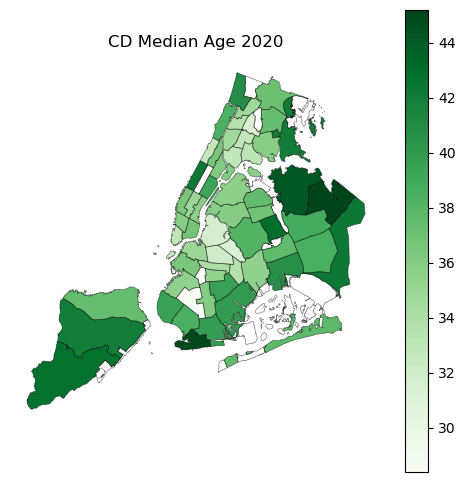

In [399]:
# Plot median age at community district level
demo_plotter(demo_aq_2020_cd, 'MdAge', 'CD Median Age 2020', 'Greens')

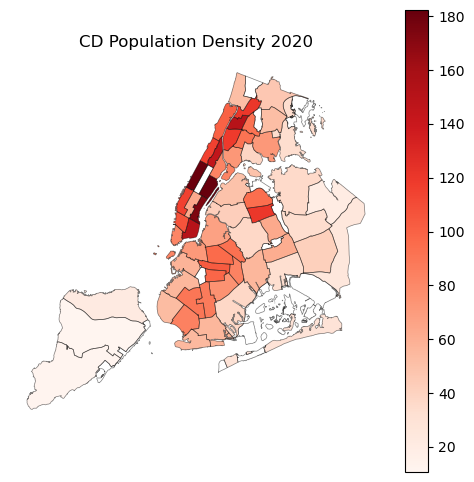

In [400]:
# Plot population density at community district level
demo_plotter(demo_aq_2020_cd, 'PopAcre', 'CD Population Density 2020', 'Reds')

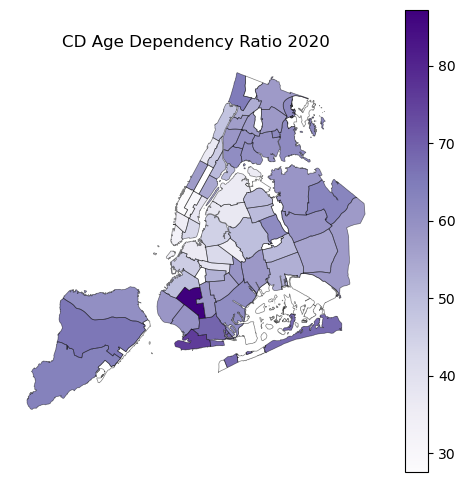

In [401]:
# Plot Age Dependency Ratio at community district level
demo_plotter(demo_aq_2020_cd, 'AgDpdRt', 'CD Age Dependency Ratio 2020', 'Purples')

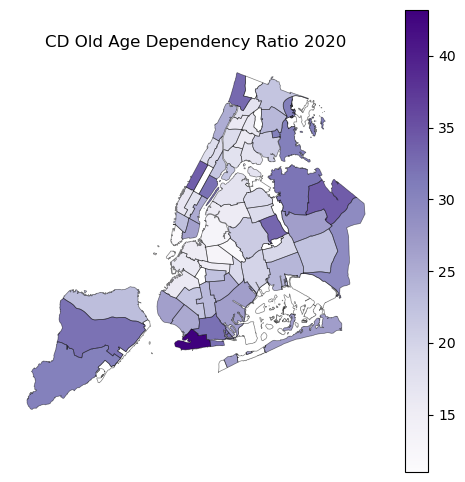

In [402]:
# Plot Old Age Dependency Ratio at community district level
demo_plotter(demo_aq_2020_cd, 'OdAgDpdRt', 'CD Old Age Dependency Ratio 2020', 'Purples')

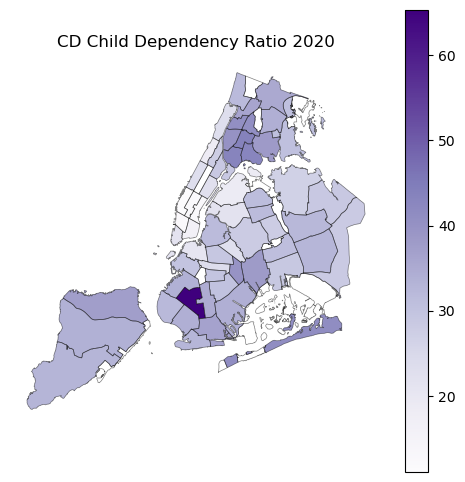

In [403]:
# Plot Child Dependency Ratio at community district level
demo_plotter(demo_aq_2020_cd, 'ChldDpdRt', 'CD Child Dependency Ratio 2020', 'Purples')

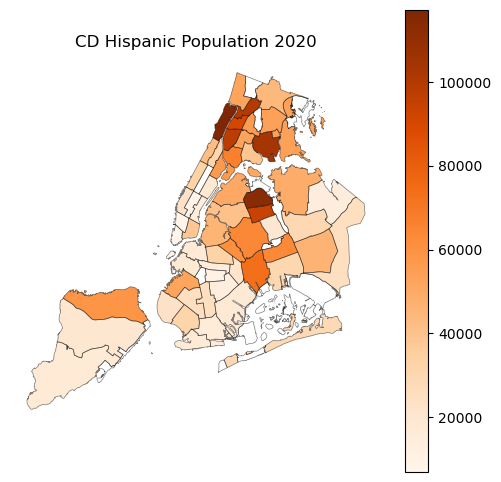

In [404]:
# Plot Hispanic Population at community district level
demo_plotter(demo_aq_2020_cd, 'Hsp1', 'CD Hispanic Population 2020', 'Oranges')

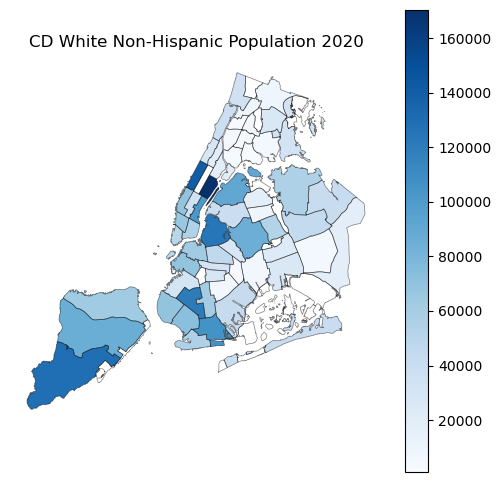

In [405]:
# Plot White Non-Hispanic Population at community district level
demo_plotter(demo_aq_2020_cd, 'WNH', 'CD White Non-Hispanic Population 2020', 'Blues')

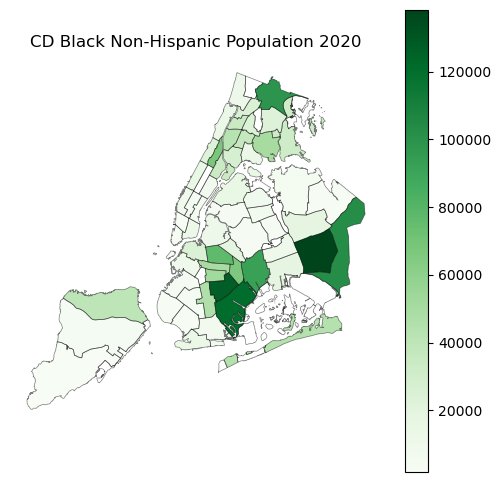

In [406]:
# Plot Black Non-Hispanic Population at community district level
demo_plotter(demo_aq_2020_cd, 'BNH', 'CD Black Non-Hispanic Population 2020', 'Greens')

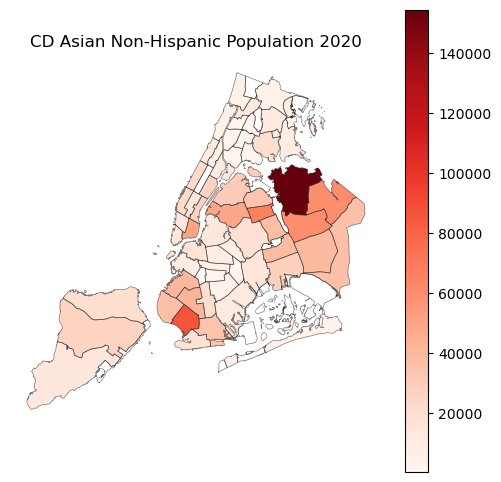

In [407]:
# Plot Asian Non-Hispanic Population at community district level
demo_plotter(demo_aq_2020_cd, 'ANH', 'CD Asian Non-Hispanic Population 2020', 'Reds')

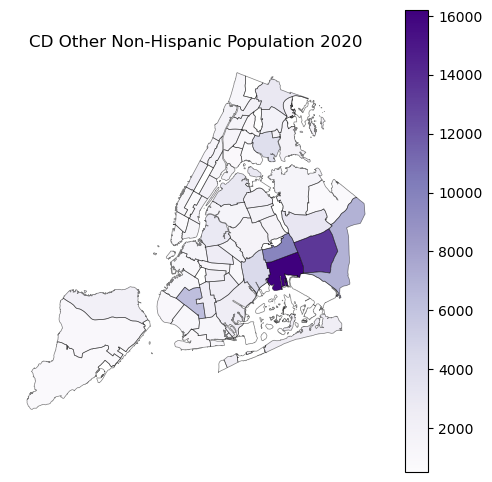

In [408]:
# Plot Other Non-Hispanic Population at community district level
demo_plotter(demo_aq_2020_cd, 'ONH', 'CD Other Non-Hispanic Population 2020', 'Purples')

By comparing the above plots, we can see that there are some overlaps between the AQ and demo data. The Bronx and Brooklyn have some community districts with high Ozone level, and these community districts also have a large population, especially the Asian Non-Hispanic population. It is also noticeable that the community districts with high Ozone level have a larger median age and a higher old age dependency ratio.

In [409]:
# Correlation between demographic data and air quality data
corr_columns = demo_aq_2020_cd[['Fine particles (PM 2.5)', 'Ozone (O3)', 'Nitrogen dioxide (NO2)', 'Pop1', 'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt', 'PopAcre', 'VHUMigWrk', 'Hsp1', 'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH']]


In [410]:
aq_demo_corr = corr_columns.corr(method='pearson')

In [411]:
aq_demo_corr.style.background_gradient(cmap='coolwarm')

,Fine particles (PM 2.5),Ozone (O3),Nitrogen dioxide (NO2),Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
Fine particles (PM 2.5),1.000000,-0.363420,0.918770,-0.335482,-0.425016,-0.708427,-0.458310,-0.548386,0.413720,0.188865,-0.017716,0.041913,-0.317071,-0.156596,-0.312199,-0.254173
Ozone (O3),-0.363420,1.000000,-0.331275,0.129454,0.204144,0.388193,0.186278,0.347911,-0.266610,-0.212701,0.324483,-0.248054,0.063276,0.185184,0.031892,-0.200723
Nitrogen dioxide (NO2),0.918770,-0.331275,1.000000,-0.293397,-0.483652,-0.626075,-0.469724,-0.436942,0.621971,0.220753,0.093894,0.001952,-0.256286,-0.224508,-0.319957,-0.250353
Pop1,-0.335482,0.129454,-0.293397,1.000000,0.281848,0.211794,0.265942,0.070122,0.030915,0.164710,0.214021,0.380903,0.250029,0.526321,0.350101,0.541617
MdAge,-0.425016,0.204144,-0.483652,0.281848,1.000000,0.342578,0.854787,-0.197030,-0.355704,-0.154386,-0.192448,0.211283,-0.029168,0.402810,0.092654,0.145767
AgDpdRt,-0.708427,0.388193,-0.626075,0.211794,0.342578,1.000000,0.597787,0.810712,-0.328080,-0.126539,0.054609,0.035624,0.116591,0.103426,0.115389,-0.091229
OdAgDpdRt,-0.458310,0.186278,-0.469724,0.265942,0.854787,0.597787,1.000000,0.015335,-0.199241,0.003862,-0.269777,0.356755,-0.073231,0.311995,0.009872,0.082316
ChldDpdRt,-0.548386,0.347911,-0.436942,0.070122,-0.197030,0.810712,0.015335,1.000000,-0.263585,-0.160734,0.265323,-0.215495,0.198142,-0.098644,0.136288,-0.173786
PopAcre,0.413720,-0.266610,0.621971,0.030915,-0.355704,-0.328080,-0.199241,-0.263585,1.000000,0.314354,0.133939,0.139516,-0.102647,-0.149281,-0.207362,0.017351
VHUMigWrk,0.188865,-0.212701,0.220753,0.164710,-0.154386,-0.126539,0.003862,-0.160734,0.314354,1.000000,-0.207175,0.303228,-0.117080,0.189263,0.068527,0.149936


In [412]:
# Drop columns that are highly correlated with each other
aq_demo_corr = aq_demo_corr[abs(aq_demo_corr) < 0.9]
# Drop columns that correlation value is less than 0.4
aq_demo_corr = aq_demo_corr[abs(aq_demo_corr) > 0.4]

In [413]:
aq_demo_corr.style.background_gradient(cmap='coolwarm')

c:\Users\chenj\anaconda3\envs\geo_env\Lib\site-packages\pandas\io\formats\style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\chenj\anaconda3\envs\geo_env\Lib\site-packages\pandas\io\formats\style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Fine particles (PM 2.5),Ozone (O3),Nitrogen dioxide (NO2),Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
Fine particles (PM 2.5),nan,nan,nan,nan,-0.425016,-0.708427,-0.458310,-0.548386,0.413720,nan,nan,nan,nan,nan,nan,nan
Ozone (O3),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Nitrogen dioxide (NO2),nan,nan,nan,nan,-0.483652,-0.626075,-0.469724,-0.436942,0.621971,nan,nan,nan,nan,nan,nan,nan
Pop1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.526321,nan,0.541617
MdAge,-0.425016,nan,-0.483652,nan,nan,nan,0.854787,nan,nan,nan,nan,nan,nan,0.402810,nan,nan
AgDpdRt,-0.708427,nan,-0.626075,nan,nan,nan,0.597787,0.810712,nan,nan,nan,nan,nan,nan,nan,nan
OdAgDpdRt,-0.458310,nan,-0.469724,nan,0.854787,0.597787,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ChldDpdRt,-0.548386,nan,-0.436942,nan,nan,0.810712,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PopAcre,0.413720,nan,0.621971,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
VHUMigWrk,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Through the correlation analysis, we found that PM2.5 and NO2 has negative correlation with Median Age, Age Dependency Ratio, Old Age Dependency Ratio, and Child Dependency Ratio. However, NO2 and population density have a strong positive correlation.

## Statistical Analysis

### Linear Regression

In [414]:
# Fit the model for PM2.5
formula_PM25 = "demo_aq_2020_cd['Fine particles (PM 2.5)'] ~ Pop1 + MdAge + AgDpdRt + OdAgDpdRt + ChldDpdRt   + Hsp1 + WNH + BNH + ANH + ONH + TwoPlNH"
model_PM25 = smf.ols(formula_PM25, data=demo_aq_2020_cd)

# Fit the model
model_PM25_fit = model_PM25.fit()

# Print summary statistics of the model's performance
model_PM25_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     demo_aq_2020_cd['Fine particles (PM 2.5)']   R-squared:                       0.709
Model:                                                    OLS   Adj. R-squared:                  0.648
Method:                                         Least Squares   F-statistic:                     11.67
Date:                                        Wed, 27 Dec 2023   Prob (F-statistic):           7.77e-10
Time:                                                08:55:18   Log-Likelihood:                -11.621
No. Observations:                                          59   AIC:                             45.24
Df Residuals:                                              48   BIC:                             68.09
Df Model:                                                  10                                         
Covariance Type:                                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1282      0.866     13.997      0.000      10.386      13.870
Pop1       -1.078e-05    3.5e-06     -3.083      0.003   -1.78e-05   -3.75e-06
MdAge         -0.0868      0.028     -3.083      0.003      -0.143      -0.030
AgDpdRt       -1.0311      0.767     -1.345      0.185      -2.572       0.510
OdAgDpdRt      1.0318      0.766      1.347      0.184      -0.508       2.572
ChldDpdRt      0.9840      0.765      1.285      0.205      -0.555       2.523
Hsp1         1.02e-05   3.57e-06      2.853      0.006    3.01e-06    1.74e-05
WNH         1.401e-05    5.1e-06      2.747      0.008    3.76e-06    2.43e-05
BNH         1.431e-05   6.03e-06      2.371      0.022    2.18e-06    2.64e-05
ANH           1.1e-05   4.36e-06      2.524      0.015    2.24e-06    1.98e-05
ONH         5.573e-05   3.05e-05      1.829      0.074   -5.55e-06       0.000
TwoPlNH       -0.0001   4.42e-05     -2.623      0.012      -0.000   -2.71e-05
==============================================================================
Omnibus:                        1.179   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                0.513
Skew:                           0.023   Prob(JB):                        0.774
Kurtosis:                       3.455   Cond. No.                     1.91e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.88e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

For PM2.5, the model explains 70.9% of the variance in the data, and the model is statistically significant (p < 0.05). PM2.5 is negatively correlated with population, median age, and positively correlated with Hispanic population, White Non-Hispanic population, Black Non-Hispanic population, Asian Non-Hispanic population, Other Non-Hispanic population, and Two or more Non-Hispanic population. 

In [415]:
# Fit the model for NO2
formula_NO2 = "demo_aq_2020_cd['Nitrogen dioxide (NO2)'] ~ Pop1 + MdAge + AgDpdRt + OdAgDpdRt + ChldDpdRt + PopAcre  + Hsp1 + WNH + BNH + ANH + ONH + TwoPlNH"
model_NO2 = smf.ols(formula_NO2, data=demo_aq_2020_cd)

# Fit the model
model_NO2_fit = model_NO2.fit()

# Print summary statistics of the model's performance
model_NO2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     demo_aq_2020_cd['Nitrogen dioxide (NO2)']   R-squared:                       0.739
Model:                                                   OLS   Adj. R-squared:                  0.678
Method:                                        Least Squares   F-statistic:                     12.13
Date:                                       Wed, 27 Dec 2023   Prob (F-statistic):           2.38e-10
Time:                                               08:55:18   Log-Likelihood:                -107.78
No. Observations:                                         59   AIC:                             239.6
Df Residuals:                                             47   BIC:                             264.5
Df Model:                                                 11                                         
Covariance Type:                                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7134      5.627      4.569      0.000      14.393      37.034
Pop1       -6.064e-05   1.83e-05     -3.307      0.002   -9.75e-05   -2.38e-05
MdAge         -0.1778      0.175     -1.017      0.315      -0.530       0.174
AgDpdRt       -9.2113      3.967     -2.322      0.025     -17.191      -1.231
OdAgDpdRt      9.1161      3.960      2.302      0.026       1.150      17.083
ChldDpdRt      9.0463      3.963      2.283      0.027       1.075      17.018
PopAcre        0.0312      0.008      4.148      0.000       0.016       0.046
Hsp1         5.34e-05   1.85e-05      2.888      0.006    1.62e-05    9.06e-05
WNH         7.692e-05   2.66e-05      2.889      0.006    2.34e-05       0.000
BNH         8.399e-05   3.16e-05      2.659      0.011    2.05e-05       0.000
ANH         5.733e-05   2.28e-05      2.519      0.015    1.15e-05       0.000
ONH            0.0003      0.000      2.108      0.040    1.58e-05       0.001
TwoPlNH       -0.0007      0.000     -2.870      0.006      -0.001      -0.000
==============================================================================
Omnibus:                        4.469   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.403
Skew:                           0.271   Prob(JB):                        0.111
Kurtosis:                       4.223   Cond. No.                     1.90e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.94e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

For NO2, the model explains 73.9% of the variance in the data, and the model is statistically significant (p < 0.05). NO2 is negatively correlated with age dependency ratio, and positively correlated with old age dependency ratio, child dependency ratio, and population density. NO2 is also positively correlated with Hispanic population, and negatively correlated with White Non-Hispanic population, Black Non-Hispanic population, Asian Non-Hispanic population, and Other Non-Hispanic population.

In [416]:
# Fit the model for Ozone
formula_O3 = "demo_aq_2020_cd['Ozone (O3)'] ~ Pop1 + AgDpdRt  + ChldDpdRt + PopAcre + VHUMigWrk + Hsp1 + WNH + BNH + ANH"
model_O3 = smf.ols(formula_O3, data=demo_aq_2020_cd)

# Fit the model
model_O3_fit = model_O3.fit()

# Print summary statistics of the model's performance
model_O3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     demo_aq_2020_cd['Ozone (O3)']   R-squared:                       0.335
Model:                                       OLS   Adj. R-squared:                  0.213
Method:                            Least Squares   F-statistic:                     2.744
Date:                           Wed, 27 Dec 2023   Prob (F-statistic):             0.0112
Time:                                   08:55:18   Log-Likelihood:                -78.695
No. Observations:                             59   AIC:                             177.4
Df Residuals:                                 49   BIC:                             198.2
Df Model:                                      9                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.1813      0.840     33.538      0.000      26.493      29.870
Pop1         -2.7e-05   3.35e-05     -0.806      0.424   -9.43e-05    4.03e-05
AgDpdRt        0.0383      0.023      1.664      0.102      -0.008       0.085
ChldDpdRt     -0.0142      0.029     -0.488      0.628      -0.073       0.044
PopAcre       -0.0041      0.004     -1.051      0.298      -0.012       0.004
VHUMigWrk     -0.0161      0.043     -0.375      0.709      -0.102       0.070
Hsp1        3.808e-05   3.44e-05      1.107      0.274   -3.11e-05       0.000
WNH         2.314e-05   3.54e-05      0.654      0.516    -4.8e-05    9.42e-05
BNH         2.952e-05   3.74e-05      0.789      0.434   -4.57e-05       0.000
ANH         3.548e-05   3.55e-05      1.001      0.322   -3.58e-05       0.000
==============================================================================
Omnibus:                        6.122   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.331
Skew:                          -0.334   Prob(JB):                       0.0256
Kurtosis:                       4.593   Cond. No.                     1.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For Ozone, the linear regression model is not a good fit.

# Future Plans



This is a preliminary analysis of the relationship between demographic data and air quality data of NYC, and there are still several factors that have not yet been examined. For example, the number of illness is not considered in the statistical model. In addition, the air quality data and the demographic data are only for 2020. The air quality data and the demographic data for other years can be considered to see if there is a change in the relationship between demographic data and air quality data over time.

It is also worth noting that the time periods for the air quality datasets are not consistent. For example, the time period for ozone is "summer 2020" while the time period for NO2 and PM 2.5 is "all of 2020". As a result, the analysis may not be able to cover differences in air quality between seasons.

Future work could examine this relationship in greater depth, consider broader time scales and resolve inconsistencies to gain more comprehensive insights.